测试DVI正态近似的准确性

In [39]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os, json 

import gaussian_variables as gv
import utils as u
import plot_utils as pu
import bayes_layers as bnn
from bayes_models import MLP, PointMLP, AdaptedMLP

np.random.seed(3)

首先构建数据集：
\begin{equation}
    y = -(x+0.5)\sin(3\pi x) + \eta
\end{equation}


\begin{equation}
    \eta = 0.45(x + 0.5)^2
\end{equation}

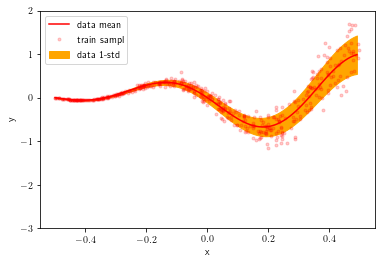

In [40]:
def base_model(x):
    return -(x+0.5)*np.sin(3 * np.pi *x)

def noise_model(x):
    return 0.45*(x+0.5)**2

def sample_data(x):
    return base_model(x) + np.random.normal(0, noise_model(x))

data_size = {'train': 500, 'valid': 100, 'test': 100}
toy_data = []
for section in ['train', 'valid', 'test']:
    x = (np.random.rand(data_size['train'], 1) - 0.5)
    toy_data.append([x, sample_data(x).reshape(-1)])    
x = np.arange(-1,1,1/100)
toy_data.append([[[_] for _ in x], base_model(x)])

pu.toy_results_plot(toy_data, {'mean':base_model, 'std':noise_model})

设置模型参数，这里以一个三层、每层5个神经元的网络为例(本项目中的其他网络结果修改“hidden_dims”参数可得到)

In [41]:
hypers = {
    "x_dim": 1,                                "y_dim": 2,
    "hidden_dims": [5,5,5],                  "nonlinearity": "relu",
    "adapter": {
        'in' : {"scale": [[1.0]], "shift": [[0.0]]},
        'out': {"scale": [[1.0, 0.83]], "shift": [[0.0, -3.5]]}
    },
    
    "method": "bayes",                         "style": "heteroskedastic",
    "homo_logvar_scale": 2*np.log(0.2),        "prior_type": ["empirical", "wider_he", "wider_he"],
    
    "n_epochs": 20000,                         "batch_size": 500,
    "learning_rate": 0.001,                    "lambda": 1.0,
    "warmup_updates": {'lambda': 14000.0},     "anneal_updates": {'lambda': 1000.0},
    "optimizer": "adam",                       "gradient_clip": 0.1,

    "data_fraction": 1.0,                      "sections_to_run": ["train"]
}

构建模型

In [42]:
def make_model(hypers):
    if hypers['method'].lower().strip() == 'bayes':
        MLP_factory = MLP
        prediction = lambda y: tf.reshape(y.mean[:,0], [-1])
        loss = bnn.regression_loss
    else:
        MLP_factory = PointMLP
        prediction = lambda y: tf.reshape(y.mean[:,0], [-1])
        loss = bnn.point_regression_loss
        
    mlp = MLP_factory(hypers['x_dim'], hypers['y_dim'], hypers)
    mlp = AdaptedMLP(mlp)
    mlp.make_placeholders()
    ipt = mlp.placeholders['ipt_mean']
    y = mlp(ipt)
    target = tf.placeholder(tf.float32, [None])
    mlp.placeholders['target'] = target
    global_step = tf.Variable(0, trainable=False, name='global_step')
    loss, logprob, all_surprise = loss(y, target, mlp, hypers, global_step)

    accuracy = tf.reduce_mean(tf.abs(target - prediction(y)))
    
    return {
        'model': mlp,
        'metrics': {
            'accuracy': accuracy,   'loss': loss,
            'logprob': logprob,     'all_surprise': all_surprise
            },
        'global_step': global_step}

给出一个比较DVI和MCVI算法结果的函数

In [43]:
from scipy import stats
def show_compare(model_and_metrics, sess):
    plt.figure()
    n_samp = 20000
    x = 0.25
    ipt = [[[x]] for _ in range(n_samp)]

    sample_op = model_and_metrics['model'].run_with_MC(
        ipt, n_sample=n_samp)
    approx_op = model_and_metrics['model'](x)
    samples = sess.run(sample_op)
    approx = sess.run([approx_op.mean, approx_op.var])

    # samples_b.shape
    m_min = stats.norm.ppf(
        0.0001, loc=approx[0][0, 0], scale=np.sqrt(approx[1][0, 0, 0]))
    m_max = stats.norm.ppf(
        0.9999, loc=approx[0][0, 0], scale=np.sqrt(approx[1][0, 0, 0]))
    l_min = stats.norm.ppf(
        0.0001, loc=approx[0][0, 1], scale=np.sqrt(approx[1][0, 1, 1]))
    l_max = stats.norm.ppf(
        0.9999, loc=approx[0][0, 1], scale=np.sqrt(approx[1][0, 1, 1]))

    bin_no_m = np.linspace(m_min, m_max, 50)
    bin_no_l = np.linspace(l_min, l_max, 50)

    fig = plt.figure()

    ax1 = fig.add_subplot(221)
    ax1.hist(samples[:, 0, 0], bin_no_m,
             density=True, edgecolor='k', facecolor='#b4c7e7')
    ax1.plot(*gaussian1d(approx[0][0, 0], approx[1][0, 0, 0],
                         m_min, m_max), 'b')
    plt.xlim([m_min, m_max])
    ax1.set_yticks([])
    ax1.set_xlabel('$m$')
    ax1.set_ylabel('$q(m)$')

    ax2 = fig.add_subplot(222)
    ax2.hist(samples[:, 0, 1], bin_no_l,
             density=True, edgecolor='k', facecolor='#b4c7e7', label="MC")

    ax2.plot(*gaussian1d(approx[0][0, 1],
                         approx[1][0, 1, 1],
                         l_min,
                         l_max), 'b', label="ours")
    plt.xlim([l_min, l_max])
    ax2.set_yticks([])
    ax2.set_xlabel('$\ell$')
    ax2.set_ylabel('$q(\ell)$')
    plt.show()
    return None

In [44]:
def gaussian1d(mean, var, min, max):
    x_axis = np.linspace(min, max, 1000)
    return x_axis, 1.0 / np.sqrt(2.0 * np.pi * var) * \
        np.exp(-1.0 / (2.0 * var) * (x_axis - mean)**2)

定义训练函数

In [45]:
def run(data):
    run_id = u.start_run()

    restricted_training_set = u.restrict_dataset_size(data[0], hypers['data_fraction'])
    hypers['dataset_size'] = len(restricted_training_set[0])

    device_id = 1
    device_string = u.get_device_string(device_id)
    print(hypers)
    with tf.device(device_string):
        if True:
            model_and_metrics = make_model(hypers)
            train_op = u.make_optimizer(model_and_metrics, hypers)
            sess = u.get_session()
            saver = tf.train.Saver()

            all_summaries = []
            best_valid_accuracy = np.inf

        show_compare(model_and_metrics, sess)

        for epoch in range(hypers['n_epochs']):
            verbose = (epoch % 20 == 0)
            if verbose:
                print("Epoch %i:        " % epoch, end='')
            epoch_summary, accuracies = u.train_valid_test(
                {
                    'train': restricted_training_set,
                    'valid': data[1],
                    'test': data[2]
                },
                sess, model_and_metrics, train_op, hypers, verbose)

        show_compare(model_and_metrics, sess)


开始训练，并得到两个DVI和MCVI之间的比较

********************************************************************************
* RUN ID: 20200104_232817_28154 
********************************************************************************
{'x_dim': 1, 'y_dim': 2, 'hidden_dims': [5, 5, 5], 'nonlinearity': 'relu', 'adapter': {'in': {'scale': [[1.0]], 'shift': [[0.0]]}, 'out': {'scale': [[1.0, 0.83]], 'shift': [[0.0, -3.5]]}}, 'method': 'bayes', 'style': 'heteroskedastic', 'homo_logvar_scale': -3.2188758248682006, 'prior_type': ['empirical', 'wider_he', 'wider_he'], 'n_epochs': 20000, 'batch_size': 500, 'learning_rate': 0.001, 'lambda': 1.0, 'warmup_updates': {'lambda': 14000.0}, 'anneal_updates': {'lambda': 1000.0}, 'optimizer': 'adam', 'gradient_clip': 0.1, 'data_fraction': 1.0, 'sections_to_run': ['train'], 'dataset_size': 500}


<Figure size 432x288 with 0 Axes>

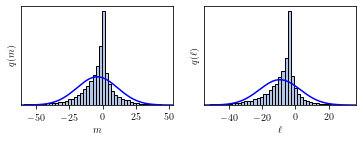

Epoch 0:         train accuracy = 2.4631 | logprob = -inf | KL term = 0.06878518676757812
Epoch 20:         train accuracy = 2.3221 | logprob = -inf | KL term = 0.07073880004882813
Epoch 40:         train accuracy = 2.1761 | logprob = -inf | KL term = 0.07277249145507812
Epoch 60:         train accuracy = 2.0272 | logprob = -inf | KL term = 0.07488713073730469
Epoch 80:         train accuracy = 1.8775 | logprob = -inf | KL term = 0.07708345031738281
Epoch 100:         train accuracy = 1.7284 | logprob = -inf | KL term = 0.07936199951171875
Epoch 120:         train accuracy = 1.5813 | logprob = -inf | KL term = 0.08172322082519531
Epoch 140:         train accuracy = 1.4293 | logprob = -inf | KL term = 0.0841532974243164
Epoch 160:         train accuracy = 1.1791 | logprob = -5625878350360481583423217991680.0000 | KL term = 0.08607627868652344
Epoch 180:         train accuracy = 0.9313 | logprob = -12647288345277070179303424.0000 | KL term = 0.08769320678710937
Epoch 200:         train a

Epoch 1700:         train accuracy = 0.3408 | logprob = -0.8003 | KL term = 0.15028204345703125
Epoch 1720:         train accuracy = 0.3408 | logprob = -0.7929 | KL term = 0.15041973876953124
Epoch 1740:         train accuracy = 0.3408 | logprob = -0.7858 | KL term = 0.15055575561523438
Epoch 1760:         train accuracy = 0.3408 | logprob = -0.7789 | KL term = 0.1506901092529297
Epoch 1780:         train accuracy = 0.3408 | logprob = -0.7724 | KL term = 0.15082286071777343
Epoch 1800:         train accuracy = 0.3408 | logprob = -0.7661 | KL term = 0.15095408630371093
Epoch 1820:         train accuracy = 0.3408 | logprob = -0.7600 | KL term = 0.15108380126953125
Epoch 1840:         train accuracy = 0.3408 | logprob = -0.7542 | KL term = 0.15121208190917967
Epoch 1860:         train accuracy = 0.3408 | logprob = -0.7487 | KL term = 0.1513389434814453
Epoch 1880:         train accuracy = 0.3408 | logprob = -0.7434 | KL term = 0.15146444702148437
Epoch 1900:         train accuracy = 0.340

Epoch 3420:         train accuracy = 0.3404 | logprob = -0.6730 | KL term = 0.15625607299804686
Epoch 3440:         train accuracy = 0.3404 | logprob = -0.6730 | KL term = 0.15628857421875
Epoch 3460:         train accuracy = 0.3404 | logprob = -0.6729 | KL term = 0.15632095336914062
Epoch 3480:         train accuracy = 0.3404 | logprob = -0.6728 | KL term = 0.15635311889648437
Epoch 3500:         train accuracy = 0.3404 | logprob = -0.6727 | KL term = 0.15638516235351563
Epoch 3520:         train accuracy = 0.3404 | logprob = -0.6727 | KL term = 0.15641702270507812
Epoch 3540:         train accuracy = 0.3404 | logprob = -0.6726 | KL term = 0.15644871520996093
Epoch 3560:         train accuracy = 0.3403 | logprob = -0.6725 | KL term = 0.15648025512695313
Epoch 3580:         train accuracy = 0.3403 | logprob = -0.6724 | KL term = 0.15651162719726563
Epoch 3600:         train accuracy = 0.3403 | logprob = -0.6724 | KL term = 0.1565428466796875
Epoch 3620:         train accuracy = 0.3403 

Epoch 5140:         train accuracy = 0.3056 | logprob = -0.5993 | KL term = 0.16439768981933595
Epoch 5160:         train accuracy = 0.3038 | logprob = -0.5938 | KL term = 0.16476429748535157
Epoch 5180:         train accuracy = 0.3019 | logprob = -0.5877 | KL term = 0.16517770385742186
Epoch 5200:         train accuracy = 0.3001 | logprob = -0.5812 | KL term = 0.16564053344726562
Epoch 5220:         train accuracy = 0.2984 | logprob = -0.5742 | KL term = 0.16615322875976563
Epoch 5240:         train accuracy = 0.2971 | logprob = -0.5670 | KL term = 0.16671368408203124
Epoch 5260:         train accuracy = 0.2961 | logprob = -0.5597 | KL term = 0.16731747436523436
Epoch 5280:         train accuracy = 0.2952 | logprob = -0.5524 | KL term = 0.16795826721191406
Epoch 5300:         train accuracy = 0.2946 | logprob = -0.5452 | KL term = 0.16862864685058593
Epoch 5320:         train accuracy = 0.2942 | logprob = -0.5382 | KL term = 0.169320556640625
Epoch 5340:         train accuracy = 0.293

Epoch 6860:         train accuracy = 0.2924 | logprob = -0.4293 | KL term = 0.19645001220703126
Epoch 6880:         train accuracy = 0.2924 | logprob = -0.4291 | KL term = 0.19664057922363282
Epoch 6900:         train accuracy = 0.2924 | logprob = -0.4289 | KL term = 0.19682977294921875
Epoch 6920:         train accuracy = 0.2924 | logprob = -0.4286 | KL term = 0.19701762390136718
Epoch 6940:         train accuracy = 0.2924 | logprob = -0.4284 | KL term = 0.19720416259765625
Epoch 6960:         train accuracy = 0.2924 | logprob = -0.4282 | KL term = 0.19738946533203125
Epoch 6980:         train accuracy = 0.2924 | logprob = -0.4280 | KL term = 0.197573486328125
Epoch 7000:         train accuracy = 0.2924 | logprob = -0.4278 | KL term = 0.19775628662109376
Epoch 7020:         train accuracy = 0.2924 | logprob = -0.4276 | KL term = 0.19793792724609374
Epoch 7040:         train accuracy = 0.2924 | logprob = -0.4274 | KL term = 0.19811837768554688
Epoch 7060:         train accuracy = 0.292

Epoch 8580:         train accuracy = 0.2927 | logprob = -0.4197 | KL term = 0.20982270812988282
Epoch 8600:         train accuracy = 0.2927 | logprob = -0.4196 | KL term = 0.20995700073242188
Epoch 8620:         train accuracy = 0.2927 | logprob = -0.4196 | KL term = 0.21009097290039064
Epoch 8640:         train accuracy = 0.2927 | logprob = -0.4195 | KL term = 0.21022470092773438
Epoch 8660:         train accuracy = 0.2927 | logprob = -0.4195 | KL term = 0.21035813903808595
Epoch 8680:         train accuracy = 0.2927 | logprob = -0.4194 | KL term = 0.21049130249023437
Epoch 8700:         train accuracy = 0.2927 | logprob = -0.4194 | KL term = 0.2106242218017578
Epoch 8720:         train accuracy = 0.2927 | logprob = -0.4193 | KL term = 0.21075689697265626
Epoch 8740:         train accuracy = 0.2927 | logprob = -0.4193 | KL term = 0.21088926696777344
Epoch 8760:         train accuracy = 0.2927 | logprob = -0.4192 | KL term = 0.21102142333984375
Epoch 8780:         train accuracy = 0.29

Epoch 10300:         train accuracy = 0.2928 | logprob = -0.4169 | KL term = 0.22065280151367186
Epoch 10320:         train accuracy = 0.2928 | logprob = -0.4169 | KL term = 0.22077290344238282
Epoch 10340:         train accuracy = 0.2928 | logprob = -0.4169 | KL term = 0.22089288330078125
Epoch 10360:         train accuracy = 0.2928 | logprob = -0.4169 | KL term = 0.2210127716064453
Epoch 10380:         train accuracy = 0.2928 | logprob = -0.4169 | KL term = 0.22113258361816407
Epoch 10400:         train accuracy = 0.2928 | logprob = -0.4169 | KL term = 0.22125228881835937
Epoch 10420:         train accuracy = 0.2928 | logprob = -0.4168 | KL term = 0.22137191772460937
Epoch 10440:         train accuracy = 0.2929 | logprob = -0.4168 | KL term = 0.221491455078125
Epoch 10460:         train accuracy = 0.2929 | logprob = -0.4168 | KL term = 0.22161093139648438
Epoch 10480:         train accuracy = 0.2929 | logprob = -0.4168 | KL term = 0.22173031616210936
Epoch 10500:         train accura

Epoch 12000:         train accuracy = 0.2929 | logprob = -0.4159 | KL term = 0.2306205291748047
Epoch 12020:         train accuracy = 0.2929 | logprob = -0.4159 | KL term = 0.2307357177734375
Epoch 12040:         train accuracy = 0.2929 | logprob = -0.4159 | KL term = 0.23085086059570312
Epoch 12060:         train accuracy = 0.2929 | logprob = -0.4159 | KL term = 0.23096597290039061
Epoch 12080:         train accuracy = 0.2929 | logprob = -0.4159 | KL term = 0.23108103942871094
Epoch 12100:         train accuracy = 0.2929 | logprob = -0.4159 | KL term = 0.23119610595703124
Epoch 12120:         train accuracy = 0.2929 | logprob = -0.4159 | KL term = 0.2313111572265625
Epoch 12140:         train accuracy = 0.2929 | logprob = -0.4159 | KL term = 0.2314261474609375
Epoch 12160:         train accuracy = 0.2929 | logprob = -0.4159 | KL term = 0.23154110717773438
Epoch 12180:         train accuracy = 0.2929 | logprob = -0.4158 | KL term = 0.231656005859375
Epoch 12200:         train accuracy 

Epoch 13700:         train accuracy = 0.2929 | logprob = -0.4155 | KL term = 0.24031234741210938
Epoch 13720:         train accuracy = 0.2929 | logprob = -0.4155 | KL term = 0.24042556762695313
Epoch 13740:         train accuracy = 0.2929 | logprob = -0.4155 | KL term = 0.24053854370117186
Epoch 13760:         train accuracy = 0.2929 | logprob = -0.4155 | KL term = 0.24065118408203126
Epoch 13780:         train accuracy = 0.2929 | logprob = -0.4155 | KL term = 0.24076422119140625
Epoch 13800:         train accuracy = 0.2929 | logprob = -0.4155 | KL term = 0.24087716674804688
Epoch 13820:         train accuracy = 0.2929 | logprob = -0.4155 | KL term = 0.24099008178710937
Epoch 13840:         train accuracy = 0.2929 | logprob = -0.4155 | KL term = 0.24110299682617187
Epoch 13860:         train accuracy = 0.2929 | logprob = -0.4155 | KL term = 0.24121589660644532
Epoch 13880:         train accuracy = 0.2929 | logprob = -0.4154 | KL term = 0.2413287811279297
Epoch 13900:         train accu

Epoch 15400:         train accuracy = 0.2595 | logprob = -0.2573 | KL term = 0.13160408020019532
Epoch 15420:         train accuracy = 0.2596 | logprob = -0.2571 | KL term = 0.1316414489746094
Epoch 15440:         train accuracy = 0.2595 | logprob = -0.2569 | KL term = 0.13167938232421875
Epoch 15460:         train accuracy = 0.2595 | logprob = -0.2567 | KL term = 0.1317197265625
Epoch 15480:         train accuracy = 0.2595 | logprob = -0.2565 | KL term = 0.13176104736328126
Epoch 15500:         train accuracy = 0.2595 | logprob = -0.2563 | KL term = 0.13180320739746093
Epoch 15520:         train accuracy = 0.2595 | logprob = -0.2561 | KL term = 0.1318460693359375
Epoch 15540:         train accuracy = 0.2595 | logprob = -0.2559 | KL term = 0.13188943481445312
Epoch 15560:         train accuracy = 0.2595 | logprob = -0.2557 | KL term = 0.13193316650390624
Epoch 15580:         train accuracy = 0.2595 | logprob = -0.2556 | KL term = 0.13197706604003906
Epoch 15600:         train accuracy 

Epoch 17120:         train accuracy = 0.1213 | logprob = 0.2242 | KL term = 0.2073403015136719
Epoch 17140:         train accuracy = 0.1207 | logprob = 0.2275 | KL term = 0.20764523315429687
Epoch 17160:         train accuracy = 0.1203 | logprob = 0.2304 | KL term = 0.20788577270507813
Epoch 17180:         train accuracy = 0.1198 | logprob = 0.2331 | KL term = 0.20807131958007813
Epoch 17200:         train accuracy = 0.1195 | logprob = 0.2355 | KL term = 0.2082093505859375
Epoch 17220:         train accuracy = 0.1191 | logprob = 0.2376 | KL term = 0.2083074645996094
Epoch 17240:         train accuracy = 0.1188 | logprob = 0.2396 | KL term = 0.20837234497070312
Epoch 17260:         train accuracy = 0.1185 | logprob = 0.2415 | KL term = 0.20841015625
Epoch 17280:         train accuracy = 0.1182 | logprob = 0.2431 | KL term = 0.20842672729492187
Epoch 17300:         train accuracy = 0.1180 | logprob = 0.2446 | KL term = 0.20842697143554687
Epoch 17320:         train accuracy = 0.1178 | lo

Epoch 18840:         train accuracy = 0.1153 | logprob = 0.2680 | KL term = 0.20509967041015625
Epoch 18860:         train accuracy = 0.1153 | logprob = 0.2681 | KL term = 0.20504336547851562
Epoch 18880:         train accuracy = 0.1152 | logprob = 0.2681 | KL term = 0.20498760986328124
Epoch 18900:         train accuracy = 0.1152 | logprob = 0.2682 | KL term = 0.2049320068359375
Epoch 18920:         train accuracy = 0.1152 | logprob = 0.2682 | KL term = 0.2048763427734375
Epoch 18940:         train accuracy = 0.1152 | logprob = 0.2683 | KL term = 0.2048207092285156
Epoch 18960:         train accuracy = 0.1152 | logprob = 0.2683 | KL term = 0.20476516723632812
Epoch 18980:         train accuracy = 0.1152 | logprob = 0.2684 | KL term = 0.20470970153808593
Epoch 19000:         train accuracy = 0.1152 | logprob = 0.2684 | KL term = 0.2046543426513672
Epoch 19020:         train accuracy = 0.1152 | logprob = 0.2685 | KL term = 0.20459913635253907
Epoch 19040:         train accuracy = 0.1152

<Figure size 432x288 with 0 Axes>

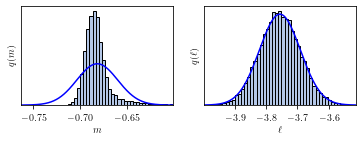

In [46]:
run(toy_data)

将之前的数据集整体增大10倍

(-11, 16)

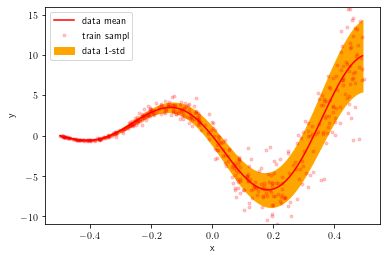

In [48]:
def base_model_10(x):
    return 10*(-(x+0.5)*np.sin(3 * np.pi *x))

def noise_model_10(x):
    return 10*(0.45*(x+0.5)**2)

def sample_data_10(x):
    return base_model_10(x) + np.random.normal(0, noise_model_10(x))

data_size = {'train': 500, 'valid': 100, 'test': 100}
toy_data = []
for section in ['train', 'valid', 'test']:
    x = (np.random.rand(data_size['train'], 1) - 0.5)
    toy_data.append([x, sample_data_10(x).reshape(-1)])    
x = np.arange(-1,1,1/100)
toy_data.append([[[_] for _ in x], base_model_10(x)])

pu.toy_results_plot(toy_data, {'mean':base_model_10, 'std':noise_model_10})
plt.ylim([-11,16])

同样的方式进行训练，并得到DVI和MCVI之间的比较

********************************************************************************
* RUN ID: 20200104_234748_28154 
********************************************************************************
{'x_dim': 1, 'y_dim': 2, 'hidden_dims': [5, 5, 5], 'nonlinearity': 'relu', 'adapter': {'in': {'scale': [[1.0]], 'shift': [[0.0]]}, 'out': {'scale': [[1.0, 0.83]], 'shift': [[0.0, -3.5]]}}, 'method': 'bayes', 'style': 'heteroskedastic', 'homo_logvar_scale': -3.2188758248682006, 'prior_type': ['empirical', 'wider_he', 'wider_he'], 'n_epochs': 20000, 'batch_size': 500, 'learning_rate': 0.001, 'lambda': 1.0, 'warmup_updates': {'lambda': 14000.0}, 'anneal_updates': {'lambda': 1000.0}, 'optimizer': 'adam', 'gradient_clip': 0.1, 'data_fraction': 1.0, 'sections_to_run': ['train'], 'dataset_size': 500}


<Figure size 432x288 with 0 Axes>

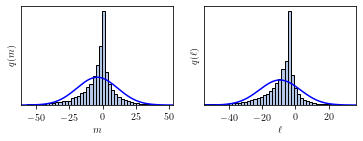

Epoch 0:         train accuracy = 4.3635 | logprob = -inf | KL term = 0.06878518676757812
Epoch 20:         train accuracy = 4.3204 | logprob = -inf | KL term = 0.07073880004882813
Epoch 40:         train accuracy = 4.2759 | logprob = -inf | KL term = 0.07277230072021484
Epoch 60:         train accuracy = 4.2179 | logprob = -inf | KL term = 0.0748834228515625
Epoch 80:         train accuracy = 4.1555 | logprob = -inf | KL term = 0.0770750961303711
Epoch 100:         train accuracy = 4.0947 | logprob = -inf | KL term = 0.07934889221191406
Epoch 120:         train accuracy = 4.0382 | logprob = -inf | KL term = 0.08170535278320312
Epoch 140:         train accuracy = 3.9845 | logprob = -inf | KL term = 0.08413069152832031
Epoch 160:         train accuracy = 3.9006 | logprob = -10542647963041986663501606682624.0000 | KL term = 0.08604893493652344
Epoch 180:         train accuracy = 3.8233 | logprob = -28144321948781160440004608.0000 | KL term = 0.08766114807128907
Epoch 200:         train a

Epoch 1680:         train accuracy = 3.5125 | logprob = -24.1234 | KL term = 0.1750203857421875
Epoch 1700:         train accuracy = 3.5079 | logprob = -21.8053 | KL term = 0.17559906005859374
Epoch 1720:         train accuracy = 3.5027 | logprob = -19.6519 | KL term = 0.17627027893066408
Epoch 1740:         train accuracy = 3.4969 | logprob = -17.6836 | KL term = 0.1770633544921875
Epoch 1760:         train accuracy = 3.4911 | logprob = -15.9102 | KL term = 0.17802879333496094
Epoch 1780:         train accuracy = 3.4867 | logprob = -14.3182 | KL term = 0.17921037292480468
Epoch 1800:         train accuracy = 3.4850 | logprob = -12.8752 | KL term = 0.180427978515625
Epoch 1820:         train accuracy = 3.4852 | logprob = -11.5665 | KL term = 0.18165565490722657
Epoch 1840:         train accuracy = 3.4867 | logprob = -10.3878 | KL term = 0.18291177368164063
Epoch 1860:         train accuracy = 3.4892 | logprob = -9.3261 | KL term = 0.18417933654785157
Epoch 1880:         train accuracy 

Epoch 3400:         train accuracy = 3.6065 | logprob = -2.7518 | KL term = 0.2141073760986328
Epoch 3420:         train accuracy = 3.6097 | logprob = -2.7481 | KL term = 0.21433506774902344
Epoch 3440:         train accuracy = 3.6128 | logprob = -2.7445 | KL term = 0.21456533813476564
Epoch 3460:         train accuracy = 3.6160 | logprob = -2.7410 | KL term = 0.21479811096191406
Epoch 3480:         train accuracy = 3.6193 | logprob = -2.7375 | KL term = 0.21503337097167968
Epoch 3500:         train accuracy = 3.6225 | logprob = -2.7342 | KL term = 0.21527093505859374
Epoch 3520:         train accuracy = 3.6257 | logprob = -2.7310 | KL term = 0.21551075744628906
Epoch 3540:         train accuracy = 3.6291 | logprob = -2.7279 | KL term = 0.215752685546875
Epoch 3560:         train accuracy = 3.6324 | logprob = -2.7249 | KL term = 0.2159966278076172
Epoch 3580:         train accuracy = 3.6356 | logprob = -2.7220 | KL term = 0.21624249267578124
Epoch 3600:         train accuracy = 3.6389 

Epoch 5120:         train accuracy = 4.4424 | logprob = -2.5363 | KL term = 0.2412930908203125
Epoch 5140:         train accuracy = 4.4443 | logprob = -2.5347 | KL term = 0.24160086059570313
Epoch 5160:         train accuracy = 4.4454 | logprob = -2.5330 | KL term = 0.24190545654296874
Epoch 5180:         train accuracy = 4.4459 | logprob = -2.5314 | KL term = 0.24220718383789064
Epoch 5200:         train accuracy = 4.4458 | logprob = -2.5298 | KL term = 0.24250631713867188
Epoch 5220:         train accuracy = 4.4451 | logprob = -2.5283 | KL term = 0.2428031005859375
Epoch 5240:         train accuracy = 4.4439 | logprob = -2.5267 | KL term = 0.24309768676757812
Epoch 5260:         train accuracy = 4.4423 | logprob = -2.5252 | KL term = 0.2433902893066406
Epoch 5280:         train accuracy = 4.4404 | logprob = -2.5236 | KL term = 0.24368106079101562
Epoch 5300:         train accuracy = 4.4381 | logprob = -2.5221 | KL term = 0.24397010803222657
Epoch 5320:         train accuracy = 4.4355

Epoch 6840:         train accuracy = 3.9841 | logprob = -2.4344 | KL term = 0.264693603515625
Epoch 6860:         train accuracy = 3.9798 | logprob = -2.4336 | KL term = 0.26496405029296877
Epoch 6880:         train accuracy = 3.9755 | logprob = -2.4328 | KL term = 0.265234130859375
Epoch 6900:         train accuracy = 3.9713 | logprob = -2.4320 | KL term = 0.2655035400390625
Epoch 6920:         train accuracy = 3.9672 | logprob = -2.4312 | KL term = 0.26577215576171875
Epoch 6940:         train accuracy = 3.9631 | logprob = -2.4304 | KL term = 0.2660397033691406
Epoch 6960:         train accuracy = 3.9590 | logprob = -2.4295 | KL term = 0.26630584716796873
Epoch 6980:         train accuracy = 3.9550 | logprob = -2.4287 | KL term = 0.26657012939453123
Epoch 7000:         train accuracy = 3.9509 | logprob = -2.4280 | KL term = 0.26683197021484373
Epoch 7020:         train accuracy = 3.9470 | logprob = -2.4272 | KL term = 0.2670904235839844
Epoch 7040:         train accuracy = 3.9430 | l

Epoch 8580:         train accuracy = 3.2843 | logprob = -1.9938 | KL term = 0.31705413818359374
Epoch 8600:         train accuracy = 3.2788 | logprob = -1.9889 | KL term = 0.31800619506835937
Epoch 8620:         train accuracy = 3.2735 | logprob = -1.9840 | KL term = 0.31896533203125
Epoch 8640:         train accuracy = 3.2683 | logprob = -1.9793 | KL term = 0.319934814453125
Epoch 8660:         train accuracy = 3.2634 | logprob = -1.9746 | KL term = 0.3209187927246094
Epoch 8680:         train accuracy = 3.2584 | logprob = -1.9699 | KL term = 0.32192095947265625
Epoch 8700:         train accuracy = 3.2529 | logprob = -1.9652 | KL term = 0.3229417419433594
Epoch 8720:         train accuracy = 3.2470 | logprob = -1.9606 | KL term = 0.3239762878417969
Epoch 8740:         train accuracy = 3.2406 | logprob = -1.9561 | KL term = 0.32501776123046877
Epoch 8760:         train accuracy = 3.2338 | logprob = -1.9516 | KL term = 0.326061279296875
Epoch 8780:         train accuracy = 3.2266 | logp

Epoch 10320:         train accuracy = 2.9126 | logprob = -1.7259 | KL term = 0.40209735107421873
Epoch 10340:         train accuracy = 2.9111 | logprob = -1.7239 | KL term = 0.40295849609375
Epoch 10360:         train accuracy = 2.9093 | logprob = -1.7218 | KL term = 0.4038265686035156
Epoch 10380:         train accuracy = 2.9076 | logprob = -1.7197 | KL term = 0.40469091796875
Epoch 10400:         train accuracy = 2.9060 | logprob = -1.7176 | KL term = 0.4055584411621094
Epoch 10420:         train accuracy = 2.9039 | logprob = -1.7155 | KL term = 0.40643182373046877
Epoch 10440:         train accuracy = 2.9015 | logprob = -1.7134 | KL term = 0.4073118591308594
Epoch 10460:         train accuracy = 2.8988 | logprob = -1.7113 | KL term = 0.40819720458984377
Epoch 10480:         train accuracy = 2.8958 | logprob = -1.7092 | KL term = 0.409074951171875
Epoch 10500:         train accuracy = 2.8927 | logprob = -1.7071 | KL term = 0.4099520263671875
Epoch 10520:         train accuracy = 2.88

Epoch 12040:         train accuracy = 2.6915 | logprob = -1.5098 | KL term = 0.4717548828125
Epoch 12060:         train accuracy = 2.6922 | logprob = -1.5087 | KL term = 0.47245431518554687
Epoch 12080:         train accuracy = 2.6929 | logprob = -1.5075 | KL term = 0.47314886474609374
Epoch 12100:         train accuracy = 2.6936 | logprob = -1.5064 | KL term = 0.4738386840820312
Epoch 12120:         train accuracy = 2.6943 | logprob = -1.5053 | KL term = 0.47452392578125
Epoch 12140:         train accuracy = 2.6950 | logprob = -1.5043 | KL term = 0.47520468139648436
Epoch 12160:         train accuracy = 2.6957 | logprob = -1.5032 | KL term = 0.4758811645507813
Epoch 12180:         train accuracy = 2.6965 | logprob = -1.5022 | KL term = 0.4765535583496094
Epoch 12200:         train accuracy = 2.6972 | logprob = -1.5012 | KL term = 0.4772218933105469
Epoch 12220:         train accuracy = 2.6979 | logprob = -1.5002 | KL term = 0.47788592529296875
Epoch 12240:         train accuracy = 2.6

Epoch 13760:         train accuracy = 2.7440 | logprob = -1.4543 | KL term = 0.5240044555664063
Epoch 13780:         train accuracy = 2.7443 | logprob = -1.4540 | KL term = 0.524509521484375
Epoch 13800:         train accuracy = 2.7445 | logprob = -1.4538 | KL term = 0.5250120849609375
Epoch 13820:         train accuracy = 2.7447 | logprob = -1.4535 | KL term = 0.5255123291015625
Epoch 13840:         train accuracy = 2.7449 | logprob = -1.4533 | KL term = 0.52601025390625
Epoch 13860:         train accuracy = 2.7451 | logprob = -1.4530 | KL term = 0.526505859375
Epoch 13880:         train accuracy = 2.7453 | logprob = -1.4528 | KL term = 0.5269989013671875
Epoch 13900:         train accuracy = 2.7455 | logprob = -1.4526 | KL term = 0.5274896240234375
Epoch 13920:         train accuracy = 2.7457 | logprob = -1.4523 | KL term = 0.52797802734375
Epoch 13940:         train accuracy = 2.7458 | logprob = -1.4521 | KL term = 0.528464111328125
Epoch 13960:         train accuracy = 2.7460 | log

Epoch 15480:         train accuracy = 2.7373 | logprob = -1.4750 | KL term = 0.35953436279296874
Epoch 15500:         train accuracy = 2.7370 | logprob = -1.4752 | KL term = 0.35918218994140627
Epoch 15520:         train accuracy = 2.7367 | logprob = -1.4754 | KL term = 0.3588370361328125
Epoch 15540:         train accuracy = 2.7365 | logprob = -1.4755 | KL term = 0.35849847412109376
Epoch 15560:         train accuracy = 2.7367 | logprob = -1.4755 | KL term = 0.3581895446777344
Epoch 15580:         train accuracy = 2.7360 | logprob = -1.4757 | KL term = 0.35780441284179687
Epoch 15600:         train accuracy = 2.7358 | logprob = -1.4758 | KL term = 0.35748245239257814
Epoch 15620:         train accuracy = 2.7355 | logprob = -1.4760 | KL term = 0.35715594482421875
Epoch 15640:         train accuracy = 2.7352 | logprob = -1.4762 | KL term = 0.35684707641601565
Epoch 15660:         train accuracy = 2.7349 | logprob = -1.4764 | KL term = 0.3565502624511719
Epoch 15680:         train accura

Epoch 17200:         train accuracy = 2.7316 | logprob = -1.4801 | KL term = 0.34190786743164064
Epoch 17220:         train accuracy = 2.7316 | logprob = -1.4802 | KL term = 0.34183477783203126
Epoch 17240:         train accuracy = 2.7316 | logprob = -1.4802 | KL term = 0.34176318359375
Epoch 17260:         train accuracy = 2.7316 | logprob = -1.4802 | KL term = 0.3416929931640625
Epoch 17280:         train accuracy = 2.7316 | logprob = -1.4802 | KL term = 0.34162417602539064
Epoch 17300:         train accuracy = 2.7316 | logprob = -1.4803 | KL term = 0.3415567016601562
Epoch 17320:         train accuracy = 2.7316 | logprob = -1.4803 | KL term = 0.3414905090332031
Epoch 17340:         train accuracy = 2.7316 | logprob = -1.4803 | KL term = 0.341425537109375
Epoch 17360:         train accuracy = 2.7316 | logprob = -1.4803 | KL term = 0.34136175537109376
Epoch 17380:         train accuracy = 2.7316 | logprob = -1.4804 | KL term = 0.34129913330078127
Epoch 17400:         train accuracy = 

Epoch 18920:         train accuracy = 2.7318 | logprob = -1.4839 | KL term = 0.3318045654296875
Epoch 18940:         train accuracy = 2.7318 | logprob = -1.4838 | KL term = 0.33178359985351563
Epoch 18960:         train accuracy = 2.7318 | logprob = -1.4838 | KL term = 0.33176470947265624
Epoch 18980:         train accuracy = 2.7318 | logprob = -1.4838 | KL term = 0.3317474670410156
Epoch 19000:         train accuracy = 2.7318 | logprob = -1.4838 | KL term = 0.3317317199707031
Epoch 19020:         train accuracy = 2.7318 | logprob = -1.4838 | KL term = 0.33171728515625
Epoch 19040:         train accuracy = 2.7319 | logprob = -1.4838 | KL term = 0.3317039794921875
Epoch 19060:         train accuracy = 2.7319 | logprob = -1.4838 | KL term = 0.33169171142578124
Epoch 19080:         train accuracy = 2.7319 | logprob = -1.4838 | KL term = 0.33168026733398437
Epoch 19100:         train accuracy = 2.7319 | logprob = -1.4838 | KL term = 0.33166961669921874
Epoch 19120:         train accuracy =

<Figure size 432x288 with 0 Axes>

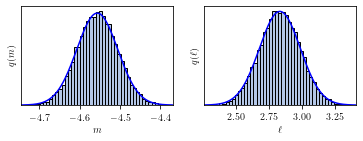

In [49]:
run(toy_data)

对于m的结果，DVI和MCVI的一致性变强了。